In [1]:
%matplotlib inline
from matplotlib import ticker 


### Load SDSS data and compute $P(R_{1/2} | M_{\ast})$ 

In [2]:
from galsize_models.measurements import load_umachine_sdss_with_meert15
full_sdss, behroozi_complete, good_profile_mask = load_umachine_sdss_with_meert15()

sdss = full_sdss[behroozi_complete & good_profile_mask]

from galsize_models.measurements import sdss_measurements as sdss_wp

from slidingpercentile import python_sliding_rank
x = sdss['logsm_bell03_meert15']
y = sdss['r50_magr_kpc_meert15']
window_length = 1001

sliding_rank_orders = python_sliding_rank(x, y, window_length)
size_percentile = (1. + sliding_rank_orders)/float(window_length+1)
sdss['r50_percentile'] = size_percentile

### Load baseline model and compute $R_{1/2}$

In [3]:
from galsize_models.models import load_orphan_mock

mock = load_orphan_mock()

from galsize_models.models import component_size_vs_rhalo

rvir = mock['rvir_zpeak']
normalization_all = 0.0125
alpha_all = 1.
scatter_all = 0.2
size_seed=14041

mock['r50_nocorr'] = component_size_vs_rhalo(rvir, 
                        normalization_all, alpha_all, 
                        scatter=scatter_all)

### Compute and plot one-point function

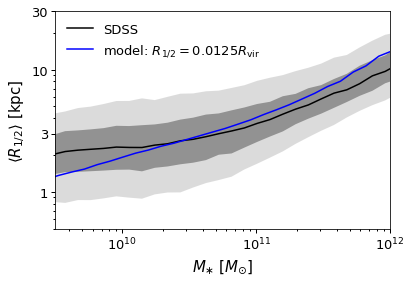

In [4]:
from scipy.special import erf, erfinv
def _percentile_from_z_score(z_score):
    return 0.5*(1 + erf(z_score/np.sqrt(2)))
low_percentile_1sigma, high_percentile_1sigma = _percentile_from_z_score(-1), _percentile_from_z_score(1)
low_percentile_3sigma, high_percentile_3sigma = _percentile_from_z_score(-3), _percentile_from_z_score(3)

logsm_table = np.linspace(9, 12.25, 35)
dlogsm = 0.05

r50_table_median = np.zeros_like(logsm_table)
r50_table_1sigma_low = np.zeros_like(logsm_table)
r50_table_1sigma_high = np.zeros_like(logsm_table)
r50_table_3sigma_low = np.zeros_like(logsm_table)
r50_table_3sigma_high = np.zeros_like(logsm_table)

for i, logsm in enumerate(logsm_table):
    mask = np.abs(sdss['logsm_bell03_meert15'] - logsm) < dlogsm
    assert np.count_nonzero(mask) > 100, logsm
    sample_r50 = sdss['r50_magr_kpc_meert15'][mask]
    sample_r50_percentile = sdss['r50_percentile'][mask]
    
    mask_median = np.abs(sample_r50_percentile - 0.5) < 0.01
    r50_table_median[i] = np.median(sample_r50[mask_median])
    
    mask_p50 = (sample_r50_percentile > 0.25) & (sample_r50_percentile < 0.75)
    r50_table_1sigma_low[i] = np.min(sample_r50[mask_p50])
    r50_table_1sigma_high[i] = np.max(sample_r50[mask_p50])

    mask_p90 = (sample_r50_percentile > 0.05) & (sample_r50_percentile < 0.95)
    r50_table_3sigma_low[i] = np.min(sample_r50[mask_p90])
    r50_table_3sigma_high[i] = np.max(sample_r50[mask_p90])

from scipy.stats import binned_statistic
mock_r50_median, __, __ = binned_statistic(
        np.log10(mock['mstar'][~mock['orphan']]), mock['r50_nocorr'][~mock['orphan']], bins=logsm_table)
logsm_mids = 0.5*(logsm_table[:-1] + logsm_table[1:])

fig, ax = plt.subplots(1, 1)
__=ax.loglog()

xmin, xmax = 10**9.5, 10**12
ymin, ymax = 0.5, 30
_xlabel = r'$M_{\ast}$ $[M_{\odot}]$'
_ylabel = r'$\langle R_{1/2} \rangle$ $[{\rm kpc}]$'
xlim = ax.set_xlim(xmin, xmax)
ylim = ax.set_ylim(ymin, ymax)
__=ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
__=ax.get_yaxis().set_minor_formatter(ticker.NullFormatter())
__=ax.set_yticks((1, 3, 10, 30))

ylabel=ax.set_ylabel(_ylabel)
xlabel=ax.set_xlabel(_xlabel)

__=ax.plot(10**logsm_table, r50_table_median, color='k', label='SDSS')
__=ax.plot(10**logsm_mids, mock_r50_median, color='blue', 
           label=r'model: $R_{1/2}=0.0125R_{\rm vir}$')

y1, y2 = r50_table_3sigma_low, r50_table_3sigma_high
__=ax.fill_between(10**logsm_table, y1, y2, facecolor='lightgray', alpha=0.8)

y1, y2 = r50_table_1sigma_low, r50_table_1sigma_high
__=ax.fill_between(10**logsm_table, y1, y2, facecolor='gray', alpha=0.8)


leg = ax.legend()

figname = 'rhalf_vs_mstar_fiducial_model.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')


## Generate predictions for several alternative models

In [5]:
from galsize_models.models import component_size_vs_rhalo

rvir = mock['rvir_zpeak']
normalization_all = 0.0125
alpha_all = 1.
scatter_all = 0.2
size_seed=14041

mock['r50_maxcorr'] = component_size_vs_rhalo(rvir, 
                        normalization_all, alpha_all, 
                        scatter=scatter_all,
                        uran=1-mock['vmax_at_mpeak_percentile'])

mock['r50_midcorr'] = component_size_vs_rhalo(rvir, 
                        normalization_all, alpha_all, 
                        scatter=scatter_all,
                        uran=1-mock['noisy_vmax_at_mpeak_percentile'])

loc = np.interp(np.log10(mock['mstar']),logsm_table, np.log10(r50_table_median))
mock['r50_mstar'] = 10**np.random.normal(loc=loc, scale=0.2)

In [6]:
logsm_bins = np.linspace(9, 12.25, 35)
logsm_mids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])


sdss_median_rhalf_table, __, __ = binned_statistic(sdss['logsm_bell03_meert15'], 
                                      sdss['r50_magr_kpc_meert15'], 
                                     bins=logsm_bins)

def frac_surviving_mstar(frac_surviving_dm, a=14.2):
    return 1 - np.exp(-a*frac_surviving_dm)

def frac_rhalf_reduction(mstar_init, frac_surviving_dm, a=14.2):
    mstar_final = frac_surviving_mstar(frac_surviving_dm)*mstar_init
    logsm_init, logsm_final = np.log10([mstar_init, mstar_final])
    initial_rhalf, final_rhalf = np.interp([logsm_init, logsm_final], 
                                          logsm_mids, sdss_median_rhalf_table)
    return final_rhalf/initial_rhalf


frac_surviving_dm = mock['mvir']/mock['mpeak']
mock['frac_surviving_mstar'] = frac_surviving_mstar(frac_surviving_dm)
mock['r50_stripping'] = mock['r50_nocorr']*frac_rhalf_reduction(mock['mstar'], frac_surviving_dm)

mock['disrupted'] = mock['orphan'] & (mock['frac_surviving_mstar'] < 0.5)

## Compute clustering ratios

In [7]:
from galsize_models.measurements import single_component_ratios

num_gals_max=int(1e5)

### $M_{\ast}-$based model

In [8]:
mock['r50'] = mock['r50_mstar']
median_rhalf_mock, __, __ = binned_statistic(
        np.log10(mock['mstar'][~mock['orphan']]), mock['r50'][~mock['orphan']], 
            bins=logsm_bins)

mock['r50_median'] = np.interp(np.log10(mock['mstar']), 
                              logsm_mids, median_rhalf_mock)

result = single_component_ratios(mock[~mock['orphan']], num_gals_max=num_gals_max)
rp_mids, fracdiff_sm9p75_mock_mstar_no_orphans, fracdiff_sm10p25_mock_mstar_no_orphans, \
fracdiff_sm10p75_mock_mstar_no_orphans, fracdiff_sm11p25_mock_mstar_no_orphans = result


### $R_{\rm vir}-$only model

In [9]:

mock['r50'] = mock['r50_nocorr']
median_rhalf_mock, __, __ = binned_statistic(
        np.log10(mock['mstar'][~mock['orphan']]), mock['r50'][~mock['orphan']], 
            bins=logsm_bins)

mock['r50_median'] = np.interp(np.log10(mock['mstar']), 
                              logsm_mids, median_rhalf_mock)

result = single_component_ratios(mock[~mock['orphan']], num_gals_max=num_gals_max)
rp_mids, fracdiff_sm9p75_mock_nocorr_no_orphans, fracdiff_sm10p25_mock_nocorr_no_orphans, \
fracdiff_sm10p75_mock_nocorr_no_orphans, fracdiff_sm11p25_mock_nocorr_no_orphans = result


### Maximum correlation model

In [10]:
mock['r50'] = mock['r50_maxcorr']
median_rhalf_mock, __, __ = binned_statistic(
        np.log10(mock['mstar'][~mock['orphan']]), mock['r50'][~mock['orphan']], 
            bins=logsm_bins)

mock['r50_median'] = np.interp(np.log10(mock['mstar']), 
                              logsm_mids, median_rhalf_mock)

result = single_component_ratios(mock[~mock['orphan']], num_gals_max=num_gals_max)
rp_mids, fracdiff_sm9p75_mock_maxcorr_no_orphans, fracdiff_sm10p25_mock_maxcorr_no_orphans, \
fracdiff_sm10p75_mock_maxcorr_no_orphans, fracdiff_sm11p25_mock_maxcorr_no_orphans = result


### $M_{\ast}$ stripping model

In [11]:
mock['r50'] = mock['r50_stripping']

median_rhalf_mock, __, __ = binned_statistic(
        np.log10(mock['mstar'][~mock['orphan']]), mock['r50'][~mock['orphan']], 
    bins=logsm_bins)

mock['r50_median'] = np.interp(np.log10(mock['mstar']), 
                              logsm_mids, median_rhalf_mock)

result = single_component_ratios(mock[~mock['orphan']], num_gals_max=num_gals_max)
rp_mids, fracdiff_sm9p75_mock_stripping_no_orphans, fracdiff_sm10p25_mock_stripping_no_orphans, \
fracdiff_sm10p75_mock_stripping_no_orphans, fracdiff_sm11p25_mock_stripping_no_orphans = result

### $R_{\rm vir}-$only model with orphans

In [12]:
mock['r50'] = mock['r50_nocorr']

median_rhalf_mock, __, __ = binned_statistic(
        np.log10(mock['mstar'][~mock['disrupted']]), mock['r50'][~mock['disrupted']], 
    bins=logsm_bins)

mock['r50_median'] = np.interp(np.log10(mock['mstar']), 
                              logsm_mids, median_rhalf_mock)

result = single_component_ratios(mock[~mock['disrupted']], num_gals_max=num_gals_max)
rp_mids, fracdiff_sm9p75_mock_nocorr_some_orphans, fracdiff_sm10p25_mock_nocorr_some_orphans, \
fracdiff_sm10p75_mock_nocorr_some_orphans, fracdiff_sm11p25_mock_nocorr_some_orphans = result

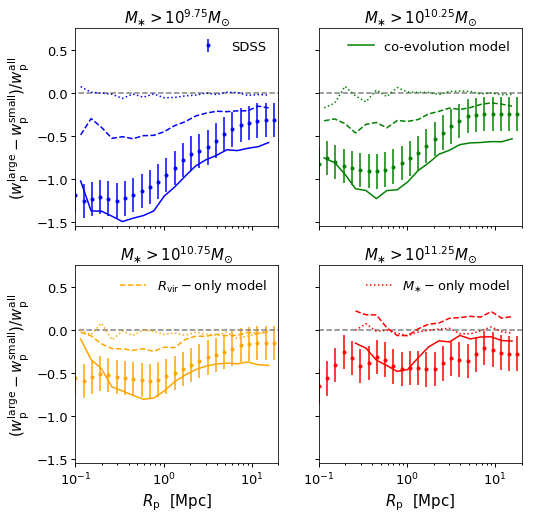

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, 
                                             figsize=(8, 8))

axes = ax1, ax2, ax3, ax4

for ax in axes:
    ylim = ax.set_ylim(-1.55, 0.75)
    xlim = ax.set_xlim(0.1, 20)
    xscale = ax.set_xscale('log')
    __=ax.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='gray')

    
__=ax4.errorbar(sdss_wp.rp, sdss_wp.fracdiff_sm11p25_smbell, sdss_wp.fracdiff_sm11p25_smbell_err, 
                fmt='.', color='red')
__=ax3.errorbar(sdss_wp.rp, sdss_wp.fracdiff_sm10p75_smbell, sdss_wp.fracdiff_sm10p75_smbell_err, 
                fmt='.', color='orange')
__=ax2.errorbar(sdss_wp.rp, sdss_wp.fracdiff_sm10p25_smbell, sdss_wp.fracdiff_sm10p25_smbell_err, 
                fmt='.', color='green')
__=ax1.errorbar(sdss_wp.rp, sdss_wp.fracdiff_sm9p75_smbell, sdss_wp.fracdiff_sm9p75_smbell_err, 
                fmt='.', color='blue', label='SDSS')

#  Maximum correlation, no orphans
__=ax4.plot(rp_mids[3:], fracdiff_sm11p25_mock_maxcorr_no_orphans[3:], color='red')
__=ax3.plot(rp_mids, fracdiff_sm10p75_mock_maxcorr_no_orphans, color='orange')
__=ax2.plot(rp_mids, fracdiff_sm10p25_mock_maxcorr_no_orphans, color='green', 
           label='co-evolution model')
__=ax1.plot(rp_mids, fracdiff_sm9p75_mock_maxcorr_no_orphans, color='blue')


#  zero correlation, no orphans
__=ax4.plot(rp_mids[3:], fracdiff_sm11p25_mock_nocorr_no_orphans[3:], '--', color='red')
__=ax3.plot(rp_mids, fracdiff_sm10p75_mock_nocorr_no_orphans, '--', color='orange', label=r'$R_{\rm vir}-$only model')
__=ax2.plot(rp_mids, fracdiff_sm10p25_mock_nocorr_no_orphans, '--', color='green')
__=ax1.plot(rp_mids, fracdiff_sm9p75_mock_nocorr_no_orphans, '--', color='blue')

#  mstar model, no orphans
__=ax4.plot(rp_mids[3:], fracdiff_sm11p25_mock_mstar_no_orphans[3:], ':', color='red', 
           label=r'$M_{\ast}-$only model')
__=ax3.plot(rp_mids, fracdiff_sm10p75_mock_mstar_no_orphans, ':', color='orange')
__=ax2.plot(rp_mids, fracdiff_sm10p25_mock_mstar_no_orphans, ':', color='green')
__=ax1.plot(rp_mids, fracdiff_sm9p75_mock_mstar_no_orphans, ':', color='blue')

__=ax4.set_title(r'$M_{\ast} > 10^{11.25}M_{\odot}$')
__=ax3.set_title(r'$M_{\ast} > 10^{10.75}M_{\odot}$')
__=ax2.set_title(r'$M_{\ast} > 10^{10.25}M_{\odot}$')
__=ax1.set_title(r'$M_{\ast} > 10^{9.75}M_{\odot}$')

ylabel1 = ax1.set_ylabel(r'$(w_{\rm p}^{\rm large} - w_{\rm p}^{\rm small}) / w_{\rm p}^{\rm all}$')
ylabel3 = ax3.set_ylabel(r'$(w_{\rm p}^{\rm large} - w_{\rm p}^{\rm small}) / w_{\rm p}^{\rm all}$')
xlabel3 = ax3.set_xlabel(r'$R_{\rm p}$  $[{\rm Mpc}]$')
xlabel4 = ax4.set_xlabel(r'$R_{\rm p}$  $[{\rm Mpc}]$')

leg1 = ax1.legend()
leg2 = ax2.legend()
leg3 = ax3.legend()
leg4 = ax4.legend()


figname = 'penultimate_clustering_ratios_no_orphans.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel3], bbox_inches='tight')


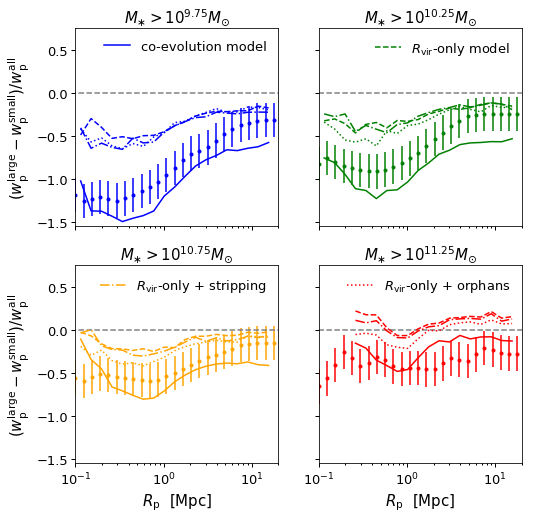

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, 
                                             figsize=(8, 8))

axes = ax1, ax2, ax3, ax4

for ax in axes:
    ylim = ax.set_ylim(-1.55, 0.75)
    xlim = ax.set_xlim(0.1, 20)
    xscale = ax.set_xscale('log')
    __=ax.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='gray')

    
__=ax4.errorbar(sdss_wp.rp, sdss_wp.fracdiff_sm11p25_smbell, sdss_wp.fracdiff_sm11p25_smbell_err, 
                fmt='.', color='red')
__=ax3.errorbar(sdss_wp.rp, sdss_wp.fracdiff_sm10p75_smbell, sdss_wp.fracdiff_sm10p75_smbell_err, 
                fmt='.', color='orange')
__=ax2.errorbar(sdss_wp.rp, sdss_wp.fracdiff_sm10p25_smbell, sdss_wp.fracdiff_sm10p25_smbell_err, 
                fmt='.', color='green')
__=ax1.errorbar(sdss_wp.rp, sdss_wp.fracdiff_sm9p75_smbell, sdss_wp.fracdiff_sm9p75_smbell_err, 
                fmt='.', color='blue', label='')

#  Maximum correlation, no orphans
__=ax4.plot(rp_mids[3:], fracdiff_sm11p25_mock_maxcorr_no_orphans[3:], color='red')
__=ax3.plot(rp_mids, fracdiff_sm10p75_mock_maxcorr_no_orphans, color='orange')
__=ax2.plot(rp_mids, fracdiff_sm10p25_mock_maxcorr_no_orphans, color='green')
__=ax1.plot(rp_mids, fracdiff_sm9p75_mock_maxcorr_no_orphans, color='blue', 
           label='co-evolution model')


#  zero correlation, no orphans
__=ax4.plot(rp_mids[3:], fracdiff_sm11p25_mock_nocorr_no_orphans[3:], '--', color='red')
__=ax3.plot(rp_mids, fracdiff_sm10p75_mock_nocorr_no_orphans, '--', color='orange')
__=ax2.plot(rp_mids, fracdiff_sm10p25_mock_nocorr_no_orphans, '--', color='green', 
           label=r'$R_{\rm vir}$-only model')
__=ax1.plot(rp_mids, fracdiff_sm9p75_mock_nocorr_no_orphans, '--', color='blue')

#  zero correlation, WITH orphans
__=ax4.plot(rp_mids[3:], fracdiff_sm11p25_mock_nocorr_some_orphans[3:], ':', color='red', 
           label=r'$R_{\rm vir}$-only + orphans')
__=ax3.plot(rp_mids, fracdiff_sm10p75_mock_nocorr_some_orphans, ':', color='orange')
__=ax2.plot(rp_mids, fracdiff_sm10p25_mock_nocorr_some_orphans, ':', color='green')
__=ax1.plot(rp_mids, fracdiff_sm9p75_mock_nocorr_some_orphans, ':', color='blue')

#  zero correlation, with stripping
__=ax4.plot(rp_mids[3:], fracdiff_sm11p25_mock_stripping_no_orphans[3:], '-.', color='red')
__=ax3.plot(rp_mids, fracdiff_sm10p75_mock_stripping_no_orphans, '-.', color='orange', 
           label=r'$R_{\rm vir}$-only + stripping')
__=ax2.plot(rp_mids, fracdiff_sm10p25_mock_stripping_no_orphans, '-.', color='green')
__=ax1.plot(rp_mids, fracdiff_sm9p75_mock_stripping_no_orphans, '-.', color='blue')

__=ax4.set_title(r'$M_{\ast} > 10^{11.25}M_{\odot}$')
__=ax3.set_title(r'$M_{\ast} > 10^{10.75}M_{\odot}$')
__=ax2.set_title(r'$M_{\ast} > 10^{10.25}M_{\odot}$')
__=ax1.set_title(r'$M_{\ast} > 10^{9.75}M_{\odot}$')

ylabel1 = ax1.set_ylabel(r'$(w_{\rm p}^{\rm large} - w_{\rm p}^{\rm small}) / w_{\rm p}^{\rm all}$')
ylabel3 = ax3.set_ylabel(r'$(w_{\rm p}^{\rm large} - w_{\rm p}^{\rm small}) / w_{\rm p}^{\rm all}$')
xlabel3 = ax3.set_xlabel(r'$R_{\rm p}$  $[{\rm Mpc}]$')
xlabel4 = ax4.set_xlabel(r'$R_{\rm p}$  $[{\rm Mpc}]$')

leg1 = ax1.legend()
leg2 = ax2.legend()
leg3 = ax3.legend()
leg4 = ax4.legend()

figname = 'penultimate_clustering_ratios_alternate_models.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel3], bbox_inches='tight')


## Co-evolution visualization

In [15]:
sample_mask = np.abs(np.log10(mock['mpeak'])-12) < 0.05

censample = mock[sample_mask*(mock['upid'] == -1)]
satsample = mock[sample_mask*(mock['upid'] != -1)*(~mock['orphan'])]

In [16]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolplanck')

from halotools.utils import crossmatch
idxA, idxB = crossmatch(censample['id'], halocat.halo_table['halo_id'])
censample['rs'] = -1.
censample['rs'][idxA] = halocat.halo_table['halo_rs'][idxB]

idxA, idxB = crossmatch(satsample['id'], halocat.halo_table['halo_id'])
satsample['rs'] = -1.
satsample['rs'][idxA] = halocat.halo_table['halo_rs'][idxB]


# fig, ax = plt.subplots(1, 1)

# small_rs_mask = censample['rs'] < np.median(censample['rs'])
# __=ax.hist(censample['r50_maxcorr'][small_rs_mask], bins=50, normed=True, color='red')
# __=ax.hist(censample['r50_maxcorr'][~small_rs_mask], bins=50, normed=True, color='blue')

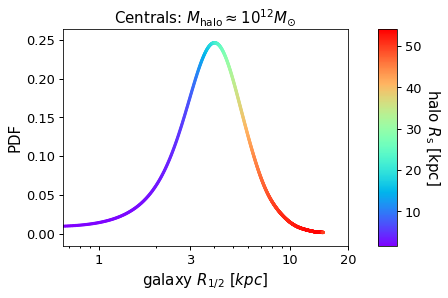

In [20]:
rhalf_bins = np.linspace(0.35, 15, 50)

rhalf_mids = 0.5*(rhalf_bins[:-1] + rhalf_bins[1:])

censample_size_pdf, __ = np.histogram(censample['r50_maxcorr'], density=True, bins=rhalf_bins)

binned_rs_mean_censample, __, __ = binned_statistic(censample['r50_maxcorr'], 
                    censample['rs'], bins=rhalf_bins, statistic='median')
censample.sort('rs')
npts = len(censample)
rs_percentile = (1. + np.arange(npts))/float(npts+1)
rs_percentile_in_bins, __, __ = binned_statistic(censample['r50_maxcorr'], 
                    rs_percentile, bins=rhalf_bins, statistic='median')

satsample_size_pdf, __ = np.histogram(satsample['r50_maxcorr'], density=True, bins=rhalf_bins)

binned_rs_mean_satsample, __, __ = binned_statistic(satsample['r50_maxcorr'], 
                    satsample['rs'], bins=rhalf_bins, statistic='median')
satsample.sort('rs')
npts_satsample = len(satsample)
rs_percentile_satsample = (1. + np.arange(npts_satsample))/float(npts_satsample+1)
rs_percentile_satsample_in_bins, __, __ = binned_statistic(satsample['r50_maxcorr'], 
                    rs_percentile_satsample, bins=rhalf_bins, statistic='median')


import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib 
import matplotlib as mpl


fig, axes = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios':[15, 1]})
xscale = axes[0].set_xscale('log')

vmin = np.median(censample['rs'][censample['r50_maxcorr'] < 1])*1000.
vmax = np.median(censample['rs'][censample['r50_maxcorr'] > 10])*1000.

cnorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

npts = int(1e3)
x = np.linspace(rhalf_mids.min(), rhalf_mids.max(), npts)
y = np.interp(x, rhalf_mids, censample_size_pdf)

y_satsample = np.interp(x, rhalf_mids, satsample_size_pdf)

from scipy.signal import savgol_filter
from scipy.ndimage.filters import gaussian_filter1d
y2 = gaussian_filter1d(y, 50)
y2_satsample = gaussian_filter1d(y_satsample, 50)

z = np.interp(x, rhalf_mids, rs_percentile_in_bins)
z_satsample = np.interp(x, rhalf_mids, rs_percentile_satsample_in_bins)

__=axes[0].scatter(x, y2, c=cm.rainbow(z), s=5)
# __=axes[0].scatter(x, y2_satsample, c=cm.rainbow(z_satsample), s=5)

from matplotlib.colorbar import ColorbarBase

my_cbar = ColorbarBase(axes[1], cmap=cm.rainbow, norm=cnorm)

my_cbar.set_label(r'$R_{\rm s}$ ${\rm [kpc]}$', rotation=-90, labelpad=20)

xlim = axes[0].set_xlim(0.65, 20)
xlabel = axes[0].set_xlabel(r'$R_{\rm 1/2}$ $[kpc]$')
ylabel = axes[0].set_ylabel(r'PDF')
title = axes[0].set_title(r'Centrals: $M_{\rm halo}\approx10^{12}M_{\odot}$')

axes[0].set_xticks((1, 3, 10, 20))
xticklabels = ['1', '3', '10', '20']
axes[0].set_xticklabels(xticklabels)

figname = 'rs_correlation_visual.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')
